In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import cv2
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import ShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import Subset
import torchvision.transforms.functional as tf
import torch.optim as optim
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import shutil

# Define the paths
input_folder = "/content/drive/MyDrive/COMPBIO/tuberculosis-phonecamera"

# List all files in the input folder
files = os.listdir(input_folder)

# Separate files into images and XML files
image_files = [file for file in files if file.endswith(".jpg")]
xml_files = [file for file in files if file.endswith(".xml")]

# Create folders within the working directory
output_image_folder = "/content/drive/MyDrive/COMPBIO/image"
output_xml_folder = "/content/drive/MyDrive/COMPBIO/xml"

os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_xml_folder, exist_ok=True)

# Copy image files to the output image folder
for image_file in image_files:
    shutil.copy(os.path.join(input_folder, image_file), os.path.join(output_image_folder, image_file))

# Copy XML files to the output XML folder
for xml_file in xml_files:
    shutil.copy(os.path.join(input_folder, xml_file), os.path.join(output_xml_folder, xml_file))

print("Separation completed successfully.")

Separation completed successfully.


In [5]:
import torch
np.random.seed(42)
torch.manual_seed(42)

In [6]:
from glob import glob


In [7]:
filenames = glob('/content/drive/MyDrive/COMPBIO/xml')
(filenames[0])

'/content/drive/MyDrive/COMPBIO/xml'

In [8]:
images = glob('/content/drive/MyDrive/COMPBIO/image')
images[0]

'/content/drive/MyDrive/COMPBIO/image'

In [9]:
import os
import xml.etree.ElementTree as ET

# Your XML data as a string

# Path to the directory containing XML files
xml_directory = '/content/drive/MyDrive/COMPBIO/xml'  # Update this with your actual directory

# Get a list of XML files in the directory
filenames = [os.path.join(xml_directory, file) for file in os.listdir(xml_directory) if file.endswith('.xml')]

# Parse the XML files
annotations = []
for xml_file in filenames:
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract xmin and ymin values for each bounding box
        bounding_boxes = []
        for obj in root.findall(".//object"):
            xmin = int(obj.find("bndbox/xmin").text)
            ymin = int(obj.find("bndbox/ymin").text)
            xmax = int(obj.find("bndbox/xmax").text)
            ymax = int(obj.find("bndbox/ymax").text)
            width = xmax - xmin
            height = ymax - ymin
            bounding_boxes.append((os.path.basename(xml_file), 1224, 1632, [xmin, ymin, width, height]))

        # Append bounding boxes to annotations
        annotations.append(bounding_boxes)

    except ET.ParseError:
        print(f"Error parsing file: {xml_file}")

# Print the result
print("List of (filename, width, height, [xmin, ymin, width, height]) values for each bounding box:")
#print(annotations)



List of (filename, width, height, [xmin, ymin, width, height]) values for each bounding box:


In [10]:
#annotations

In [11]:
annotations_1 = [item for sublist in annotations for item in sublist]

In [12]:
#annotations_1

In [13]:
import pandas as pd
# Define column names
columns = ['Image_id','width', 'height','bbox']

# Create a Pandas DataFrame
df = pd.DataFrame(annotations_1, columns=columns)
df

,Image_id,width,height,bbox
0,tuberculosis-phone-0755.xml,1224,1632,"[541, 498, 48, 75]"
1,tuberculosis-phone-0755.xml,1224,1632,"[645, 544, 55, 66]"
2,tuberculosis-phone-0755.xml,1224,1632,"[702, 591, 81, 23]"
3,tuberculosis-phone-0755.xml,1224,1632,"[886, 515, 64, 47]"
4,tuberculosis-phone-0721.xml,1224,1632,"[1043, 702, 76, 39]"
...,...,...,...,...
10071,tuberculosis-phone-0275.xml,1224,1632,"[1088, 69, 54, 66]"
10072,tuberculosis-phone-0275.xml,1224,1632,"[994, 119, 57, 51]"
10073,tuberculosis-phone-0275.xml,1224,1632,"[1107, 598, 72, 45]"
10074,tuberculosis-phone-0275.xml,1224,1632,"[380, 307, 91, 64]"


In [14]:
import os
import cv2
import pandas as pd
from xml.etree import ElementTree as ET

# Assuming you have image files in a directory
image_dir = "/content/drive/MyDrive/COMPBIO/image"
annotation_dir = "/content/drive/MyDrive/COMPBIO/xml"

# Function to parse XML annotations
def parse_xml_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        x0 = float(bbox.find('xmin').text)
        y0 = float(bbox.find('ymin').text)
        x1 = float(bbox.find('xmax').text)
        y1 = float(bbox.find('ymax').text)
        boxes.append([x0, y0, x1, y1])

    return boxes

# Read image files and annotations
image_list = os.listdir(image_dir)
tb_data = []

for img_name in image_list:
    img_path = os.path.join(image_dir, img_name)
    annotation_name = img_name.replace('.jpg', '.xml')
    annotation_path = os.path.join(annotation_dir, annotation_name)

    if os.path.exists(annotation_path):
        img = cv2.imread(img_path)
        img_height, img_width, _ = img.shape

        boxes = parse_xml_annotation(annotation_path)
        for box in boxes:
            x0, y0, x1, y1 = box
            w = x1 - x0
            h = y1 - y0

            tb_data.append({
                'image_id': img_name.replace('.jpg', ''),
                'width': img_width,
                'height': img_height,
                'x0': x0,
                'y0': y0,
                'w': w,
                'h': h
            })

# Create a DataFrame from the collected data
tb_df = pd.DataFrame(tb_data)

# Display the first few rows of the DataFrame
print(tb_df.head())


                  image_id  width  height     x0     y0      w     h
0  tuberculosis-phone-0740   1632    1224  539.0  841.0   99.0  91.0
1  tuberculosis-phone-0740   1632    1224  665.0  558.0   95.0  79.0
2  tuberculosis-phone-0740   1632    1224  362.0  335.0   99.0  52.0
3  tuberculosis-phone-0740   1632    1224  174.0  117.0   74.0  68.0
4  tuberculosis-phone-0740   1632    1224  529.0   96.0  116.0  56.0


In [15]:
tb_df.head()

,image_id,width,height,x0,y0,w,h
0,tuberculosis-phone-0740,1632,1224,539.0,841.0,99.0,91.0
1,tuberculosis-phone-0740,1632,1224,665.0,558.0,95.0,79.0
2,tuberculosis-phone-0740,1632,1224,362.0,335.0,99.0,52.0
3,tuberculosis-phone-0740,1632,1224,174.0,117.0,74.0,68.0
4,tuberculosis-phone-0740,1632,1224,529.0,96.0,116.0,56.0


In [16]:
tb_df["image_id"].nunique()
#unique_images = tb_df['Image_id'].unique()
#print(unique_images)

1220

In [17]:
dataframe=tb_df
image_dir="/content/drive/MyDrive/COMPBIO/image"
#test_dir="/kaggle/working/images"
annotation_dir="/content/drive/MyDrive/COMPBIO/xml"
model_weights_file="model.pth"

device="cuda" if torch.cuda.is_available() else "cpu"

batch_size=6
learning_rate=3e-5
epochs=15

threshold=0.5
iou_threshold=0.8

In [18]:
import os
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from xml.etree import ElementTree as ET

class TBDataset(Dataset):
    def __init__(self, dataframe, image_dir, annotation_dir):
        super().__init__()
        self.dataframe = dataframe
        self.img_list = sorted(self.dataframe["image_id"].unique())
        self.img_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = ToTensor()

    def __len__(self):
        return len(self.img_list)

    def parse_xml_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            x0 = int(bbox.find('xmin').text)
            y0 = int(bbox.find('ymin').text)
            x1 = int(bbox.find('xmax').text)
            y1 = int(bbox.find('ymax').text)
            boxes.append([x0, y0, x1, y1])

        return boxes

    def __getitem__(self, idx):
        img_name = self.img_list[idx] + ".jpg"
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)

        annotation_name = self.img_list[idx] + ".xml"
        annotation_path = os.path.join(self.annotation_dir, annotation_name)
        boxes = self.parse_xml_annotation(annotation_path)
        area = [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes]

        labels = torch.ones((len(boxes)), dtype=torch.int64)
        iscrowd = torch.zeros((len(boxes)), dtype=torch.uint8)

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "area": torch.as_tensor(area, dtype=torch.float32),
            "labels": labels,
            "iscrowd": iscrowd,
            "id": torch.tensor(idx)
        }

        return img, target

In [19]:
train_ds=TBDataset(dataframe,image_dir,annotation_dir)
val_ds=TBDataset(dataframe,image_dir,annotation_dir)

In [20]:
ss=ShuffleSplit(n_splits=1,test_size=0.2,random_state=1)

indexs=range(len(train_ds))
for train_idx,val_idx in ss.split(indexs):
    print(f"Train dataset length: {len(train_idx)}")
    print(f"Validation dataset length: {len(val_idx)}")


Train dataset length: 976
Validation dataset length: 244


In [21]:
train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

In [22]:
def show(img,boxes):
    boxes=boxes.detach().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()

    for box in boxes:
        cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(220, 0, 0), 3)

    plt.axis("off");
    plt.imshow(sample);

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [24]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=2,
                    pin_memory=True if torch.cuda.is_available else False,
                    collate_fn=collate_fn)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=2,
                  pin_memory=True if torch.cuda.is_available else False,
                  collate_fn=collate_fn)

In [25]:
# load a model pre-trained on COCO
weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model=fasterrcnn_resnet50_fpn(weights=weights)

# replace the classifier with a new one, that has
# num_classes which is user-defined
# 1 class (person) + background
num_classes = 2

# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features


# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_channels=in_features,
                                                num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 155MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [26]:
for params in model.children():
    print(params)

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [27]:
classification_head=list(model.children())[-2:]

for children in list(model.children())[:-2]:
    for params in children.parameters():
        params.requires_grad=False

parameters=[]
for heads in classification_head:
    for params in heads.parameters():
        parameters.append(params)


optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=8, threshold=0.0001)


print(classification_head)

[RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
), RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)]


In [28]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [29]:
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    training_loss=0.0
    validation_loss=0.0
    current_lr=get_lr(optimizer)

    #During training, the model expects both the input tensors, as well as a targets
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

            """The model returns a Dict[Tensor] during training, containing the classification
               and regression losses for both the RPN and the R-CNN."""

            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()

    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)

    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")


    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)

    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

Updating Best Model weights

1/15
Training Loss: 0.13901328475626765
Validation_loss: 0.12398859528733082

**************************************************
Updating Best Model weights

2/15
Training Loss: 0.11941402677263392
Validation_loss: 0.12222071651552545

**************************************************

3/15
Training Loss: 0.11746643578297779
Validation_loss: 0.1236463830363555

**************************************************
Updating Best Model weights

4/15
Training Loss: 0.11540035323285666
Validation_loss: 0.1162652893633139

**************************************************

5/15
Training Loss: 0.11281774956427637
Validation_loss: 0.11851541868975905

**************************************************

6/15
Training Loss: 0.11119234879485897
Validation_loss: 0.11858141959690657

**************************************************

7/15
Training Loss: 0.10976824662113777
Validation_loss: 0.11658170941423197

**************************************************

8/15
Tr

In [30]:
torch.save(best_weights,model_weights_file)

In [31]:
model.load_state_dict(torch.load(model_weights_file))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [32]:
def show(img,boxes,ax,color=(255,0,0)):
    boxes=boxes.detach().cpu().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()

    for box in boxes:
        cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),color, 3)

    ax.axis("off");
    ax.imshow(sample);

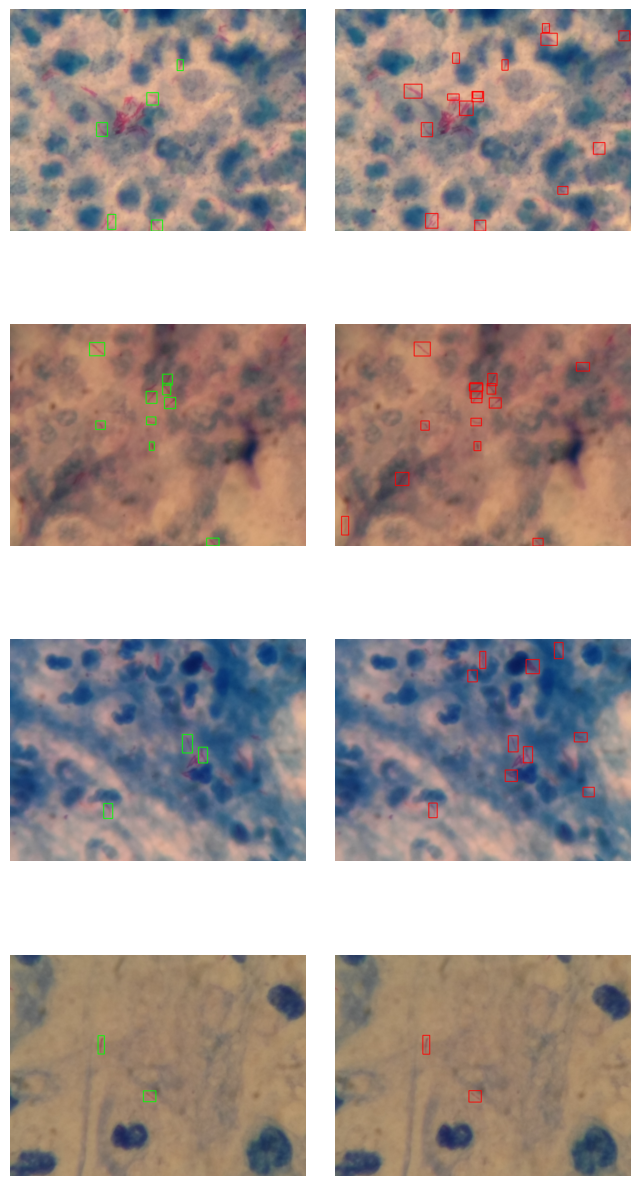

In [33]:
import matplotlib.pyplot as plt
import torchvision
import torch

fig, axes = plt.subplots(4, 2, figsize=(8, 16))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

imgs, targets = next(iter(train_dl))
model.eval()
output = model([img.to(device) for img in imgs])

threshold = 0.5
iou_threshold = 0.8

for i, idx in enumerate(range(len(imgs))):
    if i >= 4:  # Ensure we don't exceed the number of subplots
        break

    img = imgs[idx]
    predictions = output[idx]

    # Real bounding boxes
    show(img, targets[idx]["boxes"], axes[i, 0], color=(0, 255, 0))

    # Non-max suppression
    pp_boxes = predictions["boxes"][predictions["scores"] >= threshold]
    scores = predictions["scores"][predictions["scores"] >= threshold]
    nms = torchvision.ops.nms(pp_boxes, scores, iou_threshold=iou_threshold)
    pp_boxes = pp_boxes[nms]
    show(img, pp_boxes, axes[i, 1])

plt.show()


In [34]:
import torch
import torchvision

def calculate_accuracy(model, dataloader, device, threshold=0.5, iou_threshold=0.5):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for (k, v) in d.items()} for d in targets]

            # Make predictions
            output = model(imgs)

            for i in range(len(imgs)):
                predictions = output[i]
                true_boxes = targets[i]["boxes"]

                # Apply non-max suppression
                pp_boxes = predictions["boxes"][predictions["scores"] >= threshold]
                scores = predictions["scores"][predictions["scores"] >= threshold]
                nms = torchvision.ops.nms(pp_boxes, scores, iou_threshold=iou_threshold)
                pp_boxes = pp_boxes[nms]

                # Calculate accuracy
                correct_predictions += calculate_overlap_accuracy(pp_boxes, true_boxes, iou_threshold)
                total_predictions += len(true_boxes)

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
    return accuracy

def calculate_overlap_accuracy(predicted_boxes, true_boxes, iou_threshold):
    correct_predictions = 0

    for true_box in true_boxes:
        for pred_box in predicted_boxes:
            iou = calculate_iou(pred_box, true_box)
            if iou >= iou_threshold:
                correct_predictions += 1
                break  # Stop checking if one correct prediction is found

    return correct_predictions

def calculate_iou(box1, box2):
    # Calculate Intersection over Union (IoU) between two bounding boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    area1 = w1 * h1
    area2 = w2 * h2

    inter_x = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    inter_y = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    intersection = inter_x * inter_y

    union = area1 + area2 - intersection

    iou = intersection / union if union > 0 else 0.0
    return iou

# Example usage
accuracy = calculate_accuracy(model, val_dl, device, threshold=0.5, iou_threshold=0.5)
print(f"Model Accuracy: {accuracy* 100:.2f}%")

Model Accuracy: 96.49%


In [35]:
import torch
import torchvision

def calculate_metrics(model, dataloader, device, threshold=0.5, iou_threshold=0.5):
    model.eval()
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_true_boxes = 0
    total_iou = 0.0
    total_dice_score = 0.0
    total_matched_boxes = 0

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for (k, v) in t.items()} for t in targets]

            # Make predictions
            output = model(imgs)

            for i in range(len(imgs)):
                predictions = output[i]
                true_boxes = targets[i]['boxes']

                # Apply non-max suppression to predicted boxes
                pp_boxes = predictions['boxes'][predictions['scores'] >= threshold]
                scores = predictions['scores'][predictions['scores'] >= threshold]
                nms_indices = torchvision.ops.nms(pp_boxes, scores, iou_threshold=iou_threshold)
                pp_boxes = pp_boxes[nms_indices]

                # Calculate overlaps and metrics
                matched_indices = match_predictions(true_boxes, pp_boxes, iou_threshold)
                for match in matched_indices:
                    true_box = true_boxes[match[0]]
                    pred_box = pp_boxes[match[1]]
                    iou = calculate_iou(true_box, pred_box)
                    total_iou += iou
                    total_dice_score += (2 * iou) / (1 + iou)
                    total_matched_boxes += 1

                tp = len(matched_indices)
                fp = len(pp_boxes) - tp
                fn = len(true_boxes) - tp

                true_positives += tp
                false_positives += fp
                false_negatives += fn
                total_true_boxes += len(true_boxes)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / total_true_boxes if total_true_boxes > 0 else 0
    accuracy = true_positives / (true_positives + false_positives + false_negatives) if true_positives + false_positives + false_negatives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    average_iou = total_iou / total_matched_boxes if total_matched_boxes > 0 else 0
    average_dice_score = total_dice_score / total_matched_boxes if total_matched_boxes > 0 else 0

    return precision * 100, recall * 100, accuracy * 100, f1_score * 100, average_iou * 100, average_dice_score * 100

def match_predictions(true_boxes, predicted_boxes, iou_threshold):
    matched_indices = []
    for i, true_box in enumerate(true_boxes):
        for j, pred_box in enumerate(predicted_boxes):
            iou = calculate_iou(true_box, pred_box)
            if iou >= iou_threshold:
                matched_indices.append((i, j))
                break  # Stop after first match to avoid counting a prediction multiple times
    return matched_indices

def calculate_iou(box1, box2):
    # Calculate the Intersection over Union (IoU) between two bounding boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou

# Example usage
precision, recall, accuracy, f1_score, average_iou, average_dice_score = calculate_metrics(model, val_dl, device, threshold=0.5, iou_threshold=0.5)
print(f"Precision: {precision:.2f}%, Recall: {recall:.2f}%, Accuracy: {accuracy:.2f}%, F1 Score: {f1_score:.2f}%, Average IoU: {average_iou:.2f}%, Average Dice Score: {average_dice_score:.2f}%")


Precision: 50.05%, Recall: 96.49%, Accuracy: 49.16%, F1 Score: 65.91%, Average IoU: 86.97%, Average Dice Score: 92.33%


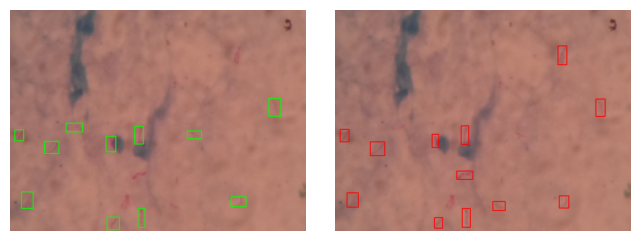

In [36]:
def show(img,boxes,ax,color=(255,0,0)):
    boxes=boxes.detach().cpu().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()

    for box in boxes:
        cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),color, 3)

    ax.axis("off");
    ax.imshow(sample);

import torchvision.transforms as T
from PIL import Image

def show(img, boxes, ax, color=None):
    img = img.permute(1, 2, 0).cpu().numpy().copy()

    if boxes is not None:
        boxes = boxes.detach().cpu().numpy().astype(np.int32)
        for box in boxes:
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 3) if color is not None else \
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 3)

    ax.axis("off")
    ax.imshow(img)

def predict_and_show(image_path, xml_path, model, threshold=0.5, iou_threshold=0.8, device="cuda"):
    transform = T.Compose([T.ToTensor()])

    # Load and transform the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Load ground truth bounding boxes from XML
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []
    for obj in root.findall(".//object"):
        bbox = obj.find("bndbox")
        x0 = int(bbox.find("xmin").text)
        y0 = int(bbox.find("ymin").text)
        x1 = int(bbox.find("xmax").text)
        y1 = int(bbox.find("ymax").text)
        boxes.append([x0, y0, x1, y1])

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    plt.subplots_adjust(wspace=0.1)

    # Real bounding boxes
    show(img_tensor.squeeze(0).cpu(), torch.tensor(boxes), axes[0], color=(0, 255, 0))

    # Non-max suppression
    pp_boxes = predictions[0]["boxes"][predictions[0]["scores"] >= threshold]
    scores = predictions[0]["scores"][predictions[0]["scores"] >= threshold]
    nms = torchvision.ops.nms(pp_boxes, scores, iou_threshold=iou_threshold)
    pp_boxes = pp_boxes[nms]
    show(img_tensor.squeeze(0).cpu(), pp_boxes, axes[1])

image_path = "/content/drive/MyDrive/COMPBIO/image/tuberculosis-phone-0222.jpg"
xml_path = "/content/drive/MyDrive/COMPBIO/xml/tuberculosis-phone-0222.xml"
predict_and_show(image_path, xml_path, model, threshold=0.5, iou_threshold=0.8, device=device)
